In [620]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.maker import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.phasediagram.analyzer import PDAnalyzer
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import math
import scipy.constants as sc

In [621]:
def high_temp_correction(e, temp):
    '''Performs high-temp correction for the supplied entry, given the new temperature.'''
    entropies = dict(O2=(205.152/2), SO2=(248.223/3), SO3=(256.77/4), P2O5=(403.96/14), CO2=(213.795/3)) #gas phase entropy values
    pressures = dict(O2=0.2, SO2=10**-6, SO3=10**-6, P2O5=10**-8, CO2=0.04) #in atm
    s_e = entropies[e.name]/sc.N_A
    h_corr = 3.5*sc.k*(temp - 298)
    p_new = pressures[e.name]
    p_std = 1
    new_miu = (0.5*(h_corr - temp*s_e + sc.k*temp*math.log(p_new/p_std)))/sc.e
    e.correction += (new_miu*e.composition.num_atoms)
#     print 'new_miu: ', new_miu
#     print 'temp*s_e: ', temp*s_e
#     print 'h_corr: ', h_corr
#     print 'entropy term: ', temp*s_e/sc.e
    return new_miu

In [622]:
def get_chempots_phases_enthalpies(chsys, formula, elem, temp=298):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','SO2','SO3']
    gas_corr_dict = dict(O2=0, SO2=0, SO3=0)
    
    with MPRester('A3e5UCcS9nTEy8xi') as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
             
    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    evolution_profile = pda.get_element_profile(Element(elem), Composition(formula))
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
        compound = PDEntry(Composition(formula), 0)
        e0 = pda.get_e_above_hull(compound)
        compound = PDEntry(Composition(formula), -(e0/Composition(formula).num_atoms))
    else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
            #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
        mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
        compound = mpentry[0]
    
    reac = [compound]
    reac.append(evolution_profile[0]['element_reference'])
    
    for stage in evolution_profile:
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(compound.name))
        enthalpies.append(rxn.calculated_reaction_energy)
        reactions.append(str(rxn))
        if abs(stage['evolution']) < 0.0001: #the compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy

    if not window: #if there is no stability window, check if it is metastable
        ehull = pda.get_e_above_hull(compound)
        if ehull > 0: #the compound is metastable
            yshift = -(ehull*comp_entry.num_atoms) #set y-shift to the e above hull for the formula unit
            
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift
        yvec.append(ynew)            
    
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c + gas_corr_dict['O2'])
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted]

In [623]:
def get_mix_stability(m_id1, m_id2, chemsys, elem, ratio, temp=298):
    '''m_id1 and m_id2 are Materials Project material identifier strings, chemsys is a list of strings of all the 
    elements in the system, and elem is the reference element. '''
    with MPRester('A3e5UCcS9nTEy8xi') as m:
        entries = m.get_entries_in_chemsys(chemsys)
        m1 = m.get_entry_by_material_id(m_id1)
        m2 = m.get_entry_by_material_id(m_id2)
    
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','CO2']
    gas_corr_dict = dict(O2=0, CO2=0)
    
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
    
    m1C = Composition(m1.name)
    m2C = Composition(m2.name)
    
    pd = PhaseDiagram(entries)
    pda = PDAnalyzer(pd)
    
    x = ratio
    E0 = m1.energy_per_atom * x + m2.energy_per_atom * (1 - x)
    comp = (1/m1C.num_atoms) * x * m1C + (1/m2C.num_atoms) * (1 - x) * m2C
    
    evolution_profile = pda.get_element_profile(Element(elem), comp)
    ref = evolution_profile[0]['element_reference']

    reac = [PDEntry(comp, E0)]
    reac.append(ref)
    
    chempots = []
    evolutions = []
    phases = []
    enthalpies = []
    yvec = []
    reactions = []
    
    for stage in evolution_profile:
        chempots.append((stage['chempot'] - ref.energy_per_atom))
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)

    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(comp))
        reactions.append(str(rxn))
        enthalpies.append(rxn.calculated_reaction_energy) 

    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = (evolutions[i]*(-chempots[i]) + enthalpies[i])
        yvec.append(ynew)            
    
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c + gas_corr_dict['O2'] + gas_corr_dict['CO2'])
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted]

In [624]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 14
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

import pandas as pnds

## LPS and LCO High Temperature Reactions

In [625]:
LPS = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')
LCO = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O')

In [626]:
pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS[0],
                      'Phase Equilibria':LPS[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LPS[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LPS[2],
                        'Reaction':LPS[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LCO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO[2],
                        'Reaction':LCO[4]})

pnds.set_option('max_colwidth', 100)

cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]

display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5,"[P2O5, Li2S2O7, SO3]",-42.358,0.000,-42.358
1,7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5,"[SO2, Li2S2O7, P2O5]",-40.587,-1.771,-14.023
2,7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7,"[SO2, Li2S2O7, LiPO3]",-38.575,-2.012,-10.401
3,6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4,"[SO2, Li2SO4, LiPO3]",-36.234,-2.341,-5.804
4,3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4 + 0.375 P2S7,"[P2S7, Li2SO4, LiPO3]",-18.722,-2.594,-2.507
5,2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li2SO4 + 0.3889 P2S7,"[Li4P2O7, Li2SO4, P2S7]",-17.739,-2.722,-1.710
6,2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7,"[P2S7, Li2SO4, Li3PO4]",-16.928,-2.807,-1.208
7,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.023,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.1111 O2 + LiCoO2 -> 0.2222 Li(CoO2)2 + 0.1111 Li7Co5O12,"[Li7Co5O12, Li(CoO2)2]",-0.084,0.000,-0.084
1,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.378,0.000
2,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",1.322,-2.644,0.000
3,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Li6CoO4, Co]",3.539,-2.660,-0.008
4,LiCoO2 -> 0.75 O2 + 0.5 Li2O + Co,"[Co, Li2O]",4.023,-2.903,-0.332
5,LiCoO2 -> O2 + Li + Co,"[Co, Li]",7.129,-6.213,-5.297


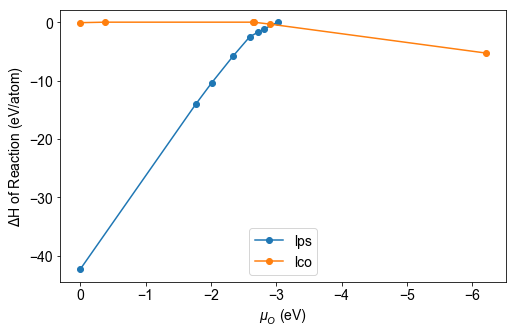

In [627]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS[0]), (LPS[2]), 'o', ls='-', label= r'lps')
p2 = plt.plot((LCO[0]), (LCO[2]), 'o', ls='-', label= r'lco')
legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

In [628]:
LPS_200 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O', temp=473)
LCO_200 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=473)

In [629]:
pnds.options.display.float_format = '{:.3f}'.format
mu_shift = '{:.3f}'.format(LPS_200[5][0])
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_200[5],
                      'Phase Equilibria':LPS_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift:LPS_200[3],
                        r'$\Delta H_{rxn}$ at $\mu_O$*':LPS_200[2],
                        'Reaction':LPS_200[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_200[5],
                      'Phase Equilibria':LCO_200[1],
                      r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift:LCO_200[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_200[2],
                        'Reaction':LCO_200[4]})
pnds.set_option('max_colwidth', 100)
cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]
display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.258,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> 4 SO3 + Li3PO4,"[SO3, Li3PO4]",-42.661,-0.258,-42.661
1,6 O2 + Li3PS4 -> 4 SO2 + Li3PO4,"[SO2, Li3PO4]",-35.504,-2.047,-14.033
2,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.216,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.258,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,0.1111 O2 + LiCoO2 -> 0.1111 Li7Co5O12 + 0.2222 Li(CoO2)2,"[Li(CoO2)2, Li7Co5O12]",-0.027,-0.258,-0.027
1,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.378,0.000
2,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",1.193,-2.644,0.000
3,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Li6CoO4, Co]",3.195,-2.660,-0.008
4,LiCoO2 -> 0.75 O2 + 0.5 Li2O + Co,"[Co, Li2O]",3.636,-2.903,-0.332
5,LiCoO2 -> O2 + Li + Co,"[Co, Li]",6.613,-6.213,-5.297


With temperature correction, the $\mu_O$ is nonzero even when T = 298 K. This is because the correction equation considers the gas entropy and the partial pressure, so there is a slight correction factor even at room temperature (previously, entropy was not considered at all).

IS X-AXIS POTENTIAL SHIFT CORRECT?

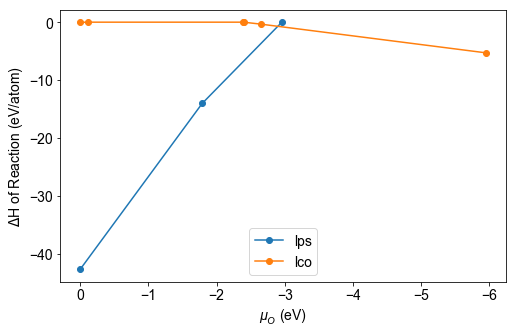

In [630]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS_200[0]), (LPS_200[2]), 'o', ls='-', label= r'lps')
p2 = plt.plot((LCO_200[0]), (LCO_200[2]), 'o', ls='-', label= r'lco')
legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

In [631]:
LPS_500 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O', temp=773)
LCO_500 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=773)

In [632]:
mu_shift = '{:.3f}'.format(LPS_500[5][0])
pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_500[5],
                      'Phase Equilibria':LPS_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift:LPS_500[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LPS_500[2],
                        'Reaction':LPS_500[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_500[5],
                      'Phase Equilibria':LCO_500[1],
                      r'$\Delta H_{rxn}$ at $\mu_O$ =' + mu_shift:LCO_500[3],
                         r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_500[2],
                        'Reaction':LCO_500[4]})
pnds.set_option('max_colwidth', 100)

cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]

display(table1)
display(table2)

,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.393,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,8 O2 + Li3PS4 -> 4 SO3 + Li3PO4,"[Li3PO4, SO3]",-44.231,-0.393,-44.231
1,6 O2 + Li3PS4 -> 4 SO2 + Li3PO4,"[Li3PO4, SO2]",-37.027,-2.194,-15.417
2,Li3PS4 -> Li3PS4,[Li3PS4],0.000,-3.478,0.000


,Reaction,Phase Equilibria,$\Delta H_{rxn}$ at $\mu_O$ =-0.393,$\mu_O$* (eV),$\Delta H_{rxn}$ at $\mu_O$*
0,LiCoO2 -> LiCoO2,[LiCoO2],-0.000,-0.393,0.000
1,LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4,"[Li6CoO4, CoO]",1.126,-2.644,0.000
2,LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4,"[Li6CoO4, Co]",3.015,-2.660,-0.008
3,LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O,"[Li2O, Co]",3.433,-2.903,-0.332
4,LiCoO2 -> O2 + Li + Co,"[Co, Li]",6.343,-6.213,-5.297


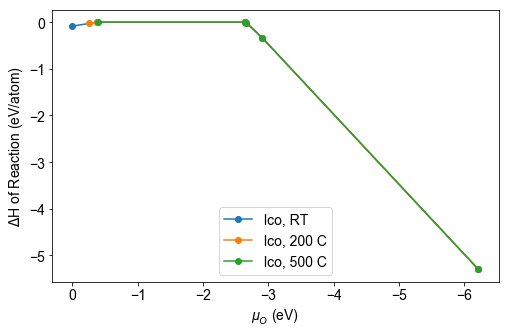

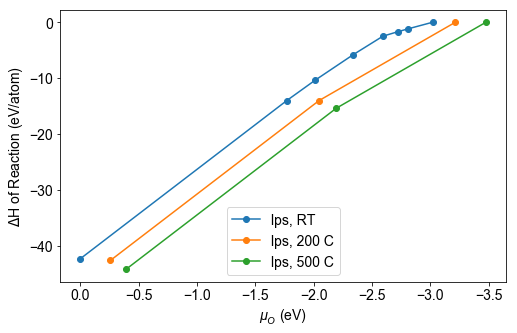

In [633]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

#p1 = plt.plot((LPS[0]), (LPS[2]), 'o', ls='-', label= r'lps, RT')
p2 = plt.plot((LCO[0]), (LCO[2]), 'o', ls='-', label= r'lco, RT')
#p3 = plt.plot((LPS_200[5]), (LPS_200[2]), 'o', ls='-', label= r'lps, 200 C')
p4 = plt.plot((LCO_200[5]), (LCO_200[2]), 'o', ls='-', label= r'lco, 200 C')
#p5 = plt.plot((LPS_500[5]), (LPS_500[2]), 'o', ls='-', label= r'lps, 500 C')
p6 = plt.plot((LCO_500[5]), (LCO_500[2]), 'o', ls='-', label= r'lco, 500 C')
legend = ax.legend(loc='lower center')

# plt.xlim(-3.5, -2.5)
# plt.ylim(-5, 1)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LPS[0]), (LPS[2]), 'o', ls='-', label= r'lps, RT')
p3 = plt.plot((LPS_200[5]), (LPS_200[2]), 'o', ls='-', label= r'lps, 200 C')
p5 = plt.plot((LPS_500[5]), (LPS_500[2]), 'o', ls='-', label= r'lps, 500 C')

legend = ax.legend(loc='lower center')
ax.invert_xaxis()
plt.show()

## LPS and LCO mix

In [610]:
LPS_LCO = get_mix_stability('mp-985583', 'mp-24850', ['Li','P','S','Co','O'], 'O', 0.5)

In [611]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
listylist = []
for r in LPS_LCO[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

norm_H1 = pnds.Series(LPS_LCO[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO[2])
norm_H2 = norm_H2*16
    
table4 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO[5],
                      'Phase Equilibria':LPS_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table4)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-45.929,-45.929,0.000,"[Li2SO4, Li2S2O7, CoPO4, CoSO4]",0.4844 O2 + LPS-LCO -> 0.03125 Li2S2O7 + 0.0625 CoSO4 + 0.0625 CoPO4 + 0.125 Li2SO4
1,-45.878,-42.744,-0.205,"[Co(PO3)3, Li2SO4, CoPO4, CoSO4]",0.4766 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.01562 Co(PO3)3 + 0.1562 Li2SO4 + 0.01563 CoPO4
2,-45.866,-42.348,-0.231,"[Li2SO4, LiCo(PO3)4, CoPO4, CoSO4]",0.475 O2 + LPS-LCO -> 0.1 CoSO4 + 0.0125 CoPO4 + 0.15 Li2SO4 + 0.0125 LiCo(PO3)4
3,-45.786,-39.747,-0.403,"[Li2SO4, Co(PO3)2, CoSO4]",0.4687 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.03125 Co(PO3)2 + 0.1562 Li2SO4
4,-33.167,-9.733,-2.403,"[Li2SO4, Co(PO3)2, Co3(PO4)2, CoS2]",0.3047 O2 + LPS-LCO -> 0.04687 CoS2 + 0.007813 Co(PO3)2 + 0.1562 Li2SO4 + 0.02344 Co3(PO4)2
5,-28.906,-9.426,-2.435,"[Li2SO4, LiCoPO4, CoS2]",0.25 O2 + LPS-LCO -> 0.0625 CoS2 + 0.125 Li2SO4 + 0.0625 LiCoPO4
6,-27.652,-8.846,-2.507,"[Li2SO4, LiPO3, LiCoPO4, Co3S4]",0.2344 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.03125 LiPO3 + 0.125 Li2SO4 + 0.03125 LiCoPO4
7,-23.872,-8.753,-2.520,"[Li4P2O7, Li2SO4, LiCoPO4, Co3S4]",0.1875 O2 + LPS-LCO -> 0.0375 Co3S4 + 0.025 Li4P2O7 + 0.1 Li2SO4 + 0.0125 LiCoPO4
8,-21.311,-8.507,-2.561,"[Li2SO4, Co3S4, Li3PO4, Li4P2O7]",0.1563 O2 + LPS-LCO -> 0.04167 Co3S4 + 0.02083 Li3PO4 + 0.08333 Li2SO4 + 0.02083 Li4P2O7
9,-18.706,-8.286,-2.605,"[Li2SO4, Co3S4, Li3PO4, CoS2]",0.125 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.0625 Li2SO4 + 0.03125 CoS2


In [612]:
LPS_LCO_200 = get_mix_stability('mp-985583', 'mp-24850', ['Li','P','S','Co','O'], 'O', 0.5, temp=473)

In [613]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
listylist = []
mu_shift = '{:.3f}'.format(LPS_LCO_200[5][0])

for r in LPS_LCO_200[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

norm_H1 = pnds.Series(LPS_LCO_200[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO_200[2])
norm_H2 = norm_H2*16

table5 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO_200[5],
                      'Phase Equilibria':LPS_LCO_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift:norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table5)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = -0.258,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-41.947,-41.947,-0.258,"[CoPO4, Li2SO4, LiCo(PO3)4, CoSO4]",0.475 O2 + LPS-LCO -> 0.1 CoSO4 + 0.0125 CoPO4 + 0.15 Li2SO4 + 0.0125 LiCo(PO3)4
1,-41.918,-39.747,-0.403,"[Li2SO4, Co(PO3)2, CoSO4]",0.4687 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.03125 Co(PO3)2 + 0.1562 Li2SO4
2,-30.653,-9.733,-2.403,"[Li2SO4, CoS2, Co(PO3)2, Co3(PO4)2]",0.3047 O2 + LPS-LCO -> 0.04687 CoS2 + 0.007813 Co(PO3)2 + 0.1562 Li2SO4 + 0.02344 Co3(PO4)2
3,-26.843,-9.426,-2.435,"[Li2SO4, CoS2, LiCoPO4]",0.25 O2 + LPS-LCO -> 0.0625 CoS2 + 0.125 Li2SO4 + 0.0625 LiCoPO4
4,-25.718,-8.846,-2.507,"[Li2SO4, LiPO3, Co3S4, LiCoPO4]",0.2344 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.03125 LiPO3 + 0.125 Li2SO4 + 0.03125 LiCoPO4
5,-22.325,-8.753,-2.520,"[Li2SO4, Co3S4, Li4P2O7, LiCoPO4]",0.1875 O2 + LPS-LCO -> 0.0375 Co3S4 + 0.025 Li4P2O7 + 0.1 Li2SO4 + 0.0125 LiCoPO4
6,-20.022,-8.507,-2.561,"[Li3PO4, Li2SO4, Co3S4, Li4P2O7]",0.1563 O2 + LPS-LCO -> 0.04167 Co3S4 + 0.02083 Li3PO4 + 0.08333 Li2SO4 + 0.02083 Li4P2O7
7,-17.675,-8.286,-2.605,"[Li3PO4, Li2SO4, Co3S4, CoS2]",0.125 O2 + LPS-LCO -> 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.0625 Li2SO4 + 0.03125 CoS2
8,-6.441,-6.441,-3.066,"[Li3PO4, Li2S, Co3S4, CoS2]",LPS-LCO -> 0.03125 Co3S4 + 0.0625 Li3PO4 + 0.0625 Li2S + 0.03125 CoS2
9,-5.288,-6.441,-3.715,"[Li3PO4, Li2S, Co3S4, Li3PS4]",LPS-LCO -> 0.01042 O2 + 0.04167 Co3S4 + 0.05729 Li3PO4 + 0.0625 Li2S + 0.005208 Li3PS4


In [614]:
LPS_LCO_500 = get_mix_stability('mp-985583', 'mp-24850', ['Li','P','S','Co','O'], 'O', 0.5, temp=773)

In [615]:
s = 'Li0.3125Co0.125P0.0625S0.25O0.25'
mu_shift = '{:.3f}'.format(LPS_LCO_500[5][0])

listylist = []
for r in LPS_LCO_500[4]:
    new = r.replace(s, 'LPS-LCO')
    listylist.append(new)

mu_shift = '{:.3f}'.format(LPS_LCO_500[5][0])

norm_H1 = pnds.Series(LPS_LCO_500[3])
norm_H1 = norm_H1*16
norm_H2 = pnds.Series(LPS_LCO_500[2])
norm_H2 = norm_H2*16

table6 = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_LCO_500[5],
                      'Phase Equilibria':LPS_LCO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift:norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':listylist})
display(table6)
pnds.set_option('max_colwidth', 400)

,$\Delta H_{rxn}$ at $\mu_O$ = -0.393,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-39.894,-39.894,-0.393,"[CoPO4, CoSO4, Li2SO4, LiCo(PO3)4]",0.475 O2 + LPS-LCO -> 0.15 Li2SO4 + 0.0125 CoPO4 + 0.1 CoSO4 + 0.0125 LiCo(PO3)4
1,-39.893,-39.747,-0.403,"[Co(PO3)2, Li2SO4, CoSO4]",0.4687 O2 + LPS-LCO -> 0.09375 CoSO4 + 0.03125 Co(PO3)2 + 0.1562 Li2SO4
2,-29.337,-9.733,-2.403,"[Co3(PO4)2, Co(PO3)2, Li2SO4, CoS2]",0.3047 O2 + LPS-LCO -> 0.04687 CoS2 + 0.02344 Co3(PO4)2 + 0.1562 Li2SO4 + 0.007813 Co(PO3)2
3,-25.763,-9.426,-2.435,"[LiCoPO4, Li2SO4, CoS2]",0.25 O2 + LPS-LCO -> 0.0625 CoS2 + 0.125 Li2SO4 + 0.0625 LiCoPO4
4,-24.706,-8.846,-2.507,"[Co3S4, Li2SO4, LiPO3, LiCoPO4]",0.2344 O2 + LPS-LCO -> 0.125 Li2SO4 + 0.03125 LiPO3 + 0.03125 Co3S4 + 0.03125 LiCoPO4
5,-21.515,-8.753,-2.520,"[Co3S4, Li2SO4, Li4P2O7, LiCoPO4]",0.1875 O2 + LPS-LCO -> 0.1 Li2SO4 + 0.025 Li4P2O7 + 0.0375 Co3S4 + 0.0125 LiCoPO4
6,-19.347,-8.507,-2.561,"[Co3S4, Li3PO4, Li2SO4, Li4P2O7]",0.1562 O2 + LPS-LCO -> 0.08333 Li2SO4 + 0.02083 Li3PO4 + 0.04167 Co3S4 + 0.02083 Li4P2O7
7,-17.135,-8.286,-2.605,"[Co3S4, Li3PO4, Li2SO4, CoS2]",0.125 O2 + LPS-LCO -> 0.0625 Li2SO4 + 0.03125 CoS2 + 0.0625 Li3PO4 + 0.03125 Co3S4
8,-6.441,-6.441,-3.066,"[Co3S4, Li3PO4, CoS2, Li2S]",LPS-LCO -> 0.0625 Li2S + 0.03125 CoS2 + 0.0625 Li3PO4 + 0.03125 Co3S4
9,-5.333,-6.441,-3.715,"[Co3S4, Li3PO4, Li2S, Li3PS4]",LPS-LCO -> 0.01042 O2 + 0.0625 Li2S + 0.05729 Li3PO4 + 0.04167 Co3S4 + 0.005208 Li3PS4


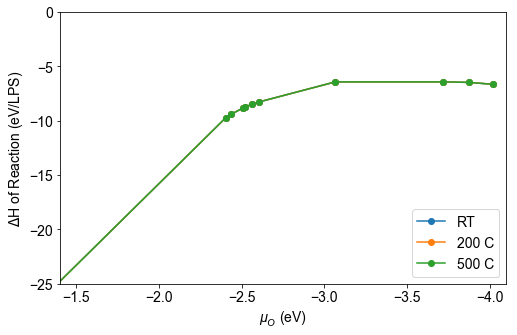

In [616]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/LPS)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LPS_LCO[2])
norm_H1 = norm_H1*16

norm_H2 = pnds.Series(LPS_LCO_200[2])
norm_H2 = norm_H2*16

norm_H3 = pnds.Series(LPS_LCO_500[2])
norm_H3 = norm_H3*16

p1 = plt.plot((LPS_LCO[0]), (norm_H1), 'o', ls='-', label= r'RT')
p2 = plt.plot((LPS_LCO_200[5]), (norm_H2), 'o', ls='-', label= r'200 C')
p3 = plt.plot((LPS_LCO_500[5]), (norm_H3), 'o', ls='-', label= r'500 C')

legend = ax.legend(loc='lower right')
plt.xlim(-4.1, -1.4)
plt.ylim(-25, 0)
#plt.gca().set_ylim(top=0)
ax.invert_xaxis()
#plt.title(r'$\Delta$H of Reaction of Li$_3$PS$_4$ with O$_2$ vs Chemical Potential')
plt.show()

In [617]:
with MPRester() as m:
    entries = m.get_entries_in_chemsys(['Li','P','S','O'])
#     mpentry = m.get_entries('Li3PS4') #gets all MP-entries associated with given composition

gas_phase_list = ['O2','SO2','SO3','P2O5']
for e in entries:
    if e.name in gas_phase_list:
        print "name: ", e.name, "mpid: ", e.entry_id, "new_miu: ", high_temp_correction(e, 600)

MPRestError: REST query returned with error status code 403. Content: {"valid_response": false, "version": {"pymatgen": "2017.9.3", "db": "2.0.0", "rest": "2.0"}, "created_at": "2017-10-10T11:55:21.732737", "error": "API_KEY is not a valid key."}

In [ ]:
lps = mpentry[0]
entropies = dict(O2=205.152, Li3PS4=248.223, SO3=256.77, P2O5=403.96)

print entropies[lps.name]
lps.correction += 10
print lps.energy

comp= lps.composition

print lps.entry_id

In [ ]:
import math
math.log(1)

## LATP and LLZO High-Temperature Calculations

In [ ]:
LATP = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O')

In [ ]:
LLZO = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O')

In [ ]:
pnds.options.display.float_format = '{:.3f}'.format
table6 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP[0],
                      'Phase Equilibria':LATP[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LATP[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP[2],
                        'Reaction':LATP[4]})
table7 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO[0],
                      'Phase Equilibria':LLZO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LLZO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LLZO[2],
                        'Reaction':LLZO[4]})

pnds.set_option('max_colwidth', 100)

cols = table6.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table6 = table6[cols]
table7 = table7[cols]

display(table6)
display(table7)

No gas phase formation here in the phase equilibria of these SSE. Now that y-axis shift is not enforced, the $\Delta H$ for the 0 chemical potential and the shifted chemical potential are quite different.

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LATP[0]), (LATP[2]), 'o', ls='-', label= r'latp')
#p2 = plt.plot((LLZO[0]), (LLZO[2]), 'o', ls='-', label= r'llzo')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

In [ ]:
LATP_200 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=473)
LATP_500 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=773)

In [ ]:
mu_shift = '{:.3f}'.format(LATP_200[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_200[5],
                      'Phase Equilibria':LATP_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LATP_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP_200[2],
                        'Reaction':LATP_200[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

In [ ]:
mu_shift = '{:.3f}'.format(LATP_500[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_500[5],
                      'Phase Equilibria':LATP_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LATP_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP_500[2],
                        'Reaction':LATP_500[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LATP_200[5]), (LATP_200[2]), 'o', ls='-', label= r'latp, 200')
p2 = plt.plot((LATP_500[5]), (LATP_500[2]), 'o', ls='-', label= r'latp, 500')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

In [ ]:
LLZO_200 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O',temp=473)
LLZO_500 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O',temp=773)

In [ ]:
mu_shift = '{:.3f}'.format(LLZO_200[5][0])
pnds.options.display.float_format = '{:.3f}'.format

pnds.options.display.float_format = '{:.3f}'.format
table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_200[5],
                      'Phase Equilibria':LLZO_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LLZO_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LLZO_200[2],
                        'Reaction':LLZO_200[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

In [ ]:
mu_shift = '{:.3f}'.format(LLZO_500[5][0])
pnds.options.display.float_format = '{:.3f}'.format

table8 = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_500[5],
                      'Phase Equilibria':LLZO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_shift: LLZO_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LLZO_500[2],
                        'Reaction':LLZO_500[4]})
pnds.set_option('max_colwidth', 100)

cols = table8.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table8 = table8[cols]

display(table8)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((LLZO[0]), (LLZO[2]), 'o', ls='-', label= r'llzo, rt')
p2 = plt.plot((LLZO_200[5]), (LLZO_200[2]), 'o', ls='-', label= r'llzo, 200')
p3 = plt.plot((LLZO_500[5]), (LLZO_500[2]), 'o', ls='-', label= r'llzo, 500')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

## LLZO and LTP mix

In [ ]:
LTP_LCO = get_mix_stability('mp-18640', 'mp-24850', ['Li','P','Ti','Co','O'], 'O', 0.5)
LTP_LCO_200 = get_mix_stability('mp-18640', 'mp-24850', ['Li','P','Ti','Co','O'], 'O', 0.5, temp=473)
LTP_LCO_500 = get_mix_stability('mp-18640', 'mp-24850', ['Li','P','Ti','Co','O'], 'O', 0.5, temp=773)

In [ ]:
s = 'Li0.15277778Ti0.05555556Co0.125P0.08333333O0.58333333'
shortname = []
for r in LTP_LCO[4]:
    new = r.replace(s, 'LTP-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LTP_LCO[3])
norm_H1 = norm_H1*36
norm_H2 = pnds.Series(LTP_LCO[2])
norm_H2 = norm_H2*36
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LTP_LCO[5],
                      'Phase Equilibria':LTP_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/LTP)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LTP_LCO[2])
norm_H1 = norm_H1*36

norm_H2 = pnds.Series(LTP_LCO_200[2])
norm_H2 = norm_H2*36

norm_H3 = pnds.Series(LTP_LCO_500[2])
norm_H3 = norm_H3*36

p1 = plt.plot((LTP_LCO[0]), (norm_H1), 'o-', label= r'RT')
p2 = plt.plot((LTP_LCO_200[5]), (norm_H2), 'o-', label= r'473 K')
p2 = plt.plot((LTP_LCO_500[5]), (norm_H3), 'o-', label= r'773 K')

legend = ax.legend(loc='lower left')
ax.invert_xaxis()
plt.show()

In [ ]:
LLZO_LCO = get_mix_stability('mp-942733', 'mp-24850', ['Li','La','Zr','Co','O'], 'O', 0.5)
LLZO_LCO_200 = get_mix_stability('mp-942733', 'mp-24850', ['Li','La','Zr','Co','O'], 'O', 0.5, temp=473)
LLZO_LCO_500 = get_mix_stability('mp-942733', 'mp-24850', ['Li','La','Zr','Co','O'], 'O', 0.5, temp=773)

In [ ]:
s = 'Li0.27083333La0.0625Zr0.04166667Co0.125O0.5'
shortname = []
for r in LLZO_LCO[4]:
    new = r.replace(s, 'LLZO-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LLZO_LCO[3])
norm_H1 = norm_H1*48
norm_H2 = pnds.Series(LLZO_LCO[2])
norm_H2 = norm_H2*48
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_LCO[5],
                      'Phase Equilibria':LLZO_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

In [ ]:
s = 'Li0.27083333La0.0625Zr0.04166667Co0.125O0.5'
shortname = []
for r in LLZO_LCO_500[4]:
    new = r.replace(s, 'LLZO-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(LLZO_LCO_500[3])
norm_H1 = norm_H1*48
norm_H2 = pnds.Series(LLZO_LCO_500[2])
norm_H2 = norm_H2*48
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LLZO_LCO_500[5],
                      'Phase Equilibria':LLZO_LCO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':shortname})
display(table)
pnds.set_option('max_colwidth', 400)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/LLZO)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(LLZO_LCO[2])
norm_H1 = norm_H1*36

norm_H2 = pnds.Series(LLZO_LCO_200[2])
norm_H2 = norm_H2*36

norm_H3 = pnds.Series(LLZO_LCO_500[2])
norm_H3 = norm_H3*36

p1 = plt.plot(LLZO_LCO[0], norm_H1, 'o-', label= r'RT')
p2 = plt.plot(LLZO_LCO_200[5], norm_H2, 'o-', label= r'473 K')
p3 = plt.plot(LLZO_LCO_500[5], norm_H3, 'o-', label= r'773 K')

plt.xlim(-3.25, 0.1)
plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower left')
ax.invert_xaxis()

plt.show()

## Anode Studies

In [ ]:
li = get_chempots_phases_enthalpies(['Li','O'],'Li','O')
c = get_chempots_phases_enthalpies(['C','O'],'C','O')
si = get_chempots_phases_enthalpies(['Si','O'],'Si','O')

In [ ]:
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':li[0],
                      'Phase Equilibria':li[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':li[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':li[2],
                        'Reaction':li[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':c[0],
                      'Phase Equilibria':c[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':c[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c[2],
                        'Reaction':c[4]})
table3 = pnds.DataFrame({r'$\mu_O$* (eV)':si[0],
                      'Phase Equilibria':si[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':si[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':si[2],
                        'Reaction':si[4]})

pnds.set_option('max_colwidth', 100)

cols = table1.columns.tolist()
neworder = [4, 3, 0, 2, 1]
cols = [cols[i] for i in neworder]
table1 = table1[cols]
table2 = table2[cols]
table3 = table3[cols]

display(table1)
display(table2)
display(table3)

In [ ]:
c_200 = get_chempots_phases_enthalpies(['Li','O'],'Li','O',temp=473)
c_500 = get_chempots_phases_enthalpies(['Li','O'],'Li','O',temp=773)

In [ ]:
mu_1 = '{:.3f}'.format(c_200[5][0])
mu_2 = '{:.3f}'.format(c_500[5][0])

pnds.options.display.float_format = '{:.3f}'.format
table1 = pnds.DataFrame({r'$\mu_O$* (eV)':li[0],
                      'Phase Equilibria':li[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':li[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':li[2],
                        'Reaction':li[4]})
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':c_200[5],
                      'Phase Equilibria':c_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = ' + mu_1:c_200[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c_200[2],
                        'Reaction':c_200[4]})
table3 = pnds.DataFrame({r'$\mu_O$* (eV)':c_500[5],
                      'Phase Equilibria':c_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = '+mu_2:c_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':c_500[2],
                        'Reaction':c_500[4]})

pnds.set_option('max_colwidth', 100)

cols1 = table1.columns.tolist()
cols2 = table2.columns.tolist()
cols3 = table3.columns.tolist()

neworder = [4, 3, 0, 2, 1]
cols1 = [cols1[i] for i in neworder]
cols2 = [cols2[i] for i in neworder]
cols3 = [cols3[i] for i in neworder]

table1 = table1[cols1]
table2 = table2[cols2]
table3 = table3[cols3]

display(table1)
display(table2)
display(table3)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot((li[0]), (li[2]), 'o-', label= r'li, rt')
p2 = plt.plot((c_200[5]), (c_200[2]), 'o-', label= r'li, 200')
p3 = plt.plot((c_500[5]), (c_500[2]), 'o-', label= r'li, 500')

legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

## Anode LCO Mix

In [ ]:
C_LCO = get_mix_stability('mp-568286', 'mp-24850', ['C','Li','Co','O'], 'O', 0.5)
C_LCO_200 = get_mix_stability('mp-568286', 'mp-24850', ['C','Li','Co','O'], 'O', 0.5, temp=473)
C_LCO_500 = get_mix_stability('mp-568286', 'mp-24850', ['C','Li','Co','O'], 'O', 0.5, temp=773)

In [ ]:
s = 'Li0.125Co0.125C0.5O0.25'
shortname = []
for r in C_LCO[4]:
    new = r.replace(s, 'C-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(C_LCO[3])
norm_H1 = norm_H1*2
norm_H2 = pnds.Series(C_LCO[2])
norm_H2 = norm_H2*2
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':C_LCO[5],
                      'Phase Equilibria':C_LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':C_LCO[4]})
display(table)
pnds.set_option('max_colwidth', 400)

In [ ]:
s = 'Li0.125Co0.125C0.5O0.25'
shortname = []
for r in C_LCO_200[4]:
    new = r.replace(s, 'C-LCO')
    shortname.append(new)

norm_H1 = pnds.Series(C_LCO_200[3])
norm_H1 = norm_H1*2
norm_H2 = pnds.Series(C_LCO_200[2])
norm_H2 = norm_H2*2
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':C_LCO_200[5],
                      'Phase Equilibria':C_LCO_200[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':norm_H1,
                    r'$\Delta H_{rxn}$ at $\mu_O$*':norm_H2,
                        'Reaction':C_LCO_200[4]})
display(table)
pnds.set_option('max_colwidth', 400)

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/C)')
ax.set_xlabel(r'$\mu_O$ (eV)')

norm_H1 = pnds.Series(C_LCO[2])
norm_H1 = norm_H1*2

norm_H2 = pnds.Series(C_LCO_200[2])
norm_H2 = norm_H2*2

norm_H3 = pnds.Series(C_LCO_500[2])
norm_H3 = norm_H3*2

p1 = plt.plot(C_LCO[0], norm_H1, 'o-', label= r'RT')
p2 = plt.plot(C_LCO_200[5], norm_H2, 'o-', label= r'473 K')
p3 = plt.plot(C_LCO_500[5], norm_H3, 'o-', label= r'773 K')

# plt.xlim(-3.25, 0.1)
# plt.ylim(-2.6, 0.5)
legend = ax.legend(loc='lower left')
ax.invert_xaxis()

plt.show()